Apply various dimensionality reduction method to straighten the distill bert positional embeddings

In [13]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from transformers import AutoModelForSequenceClassification, TrainingArguments
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

In [4]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
pos_tensor = model.distilbert.embeddings.position_embeddings.weight.data
pos_matrix = pos_tensor.to('cpu').numpy()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.6234562210738659


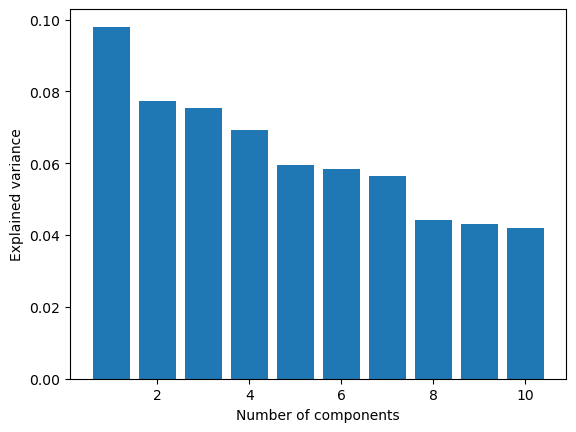

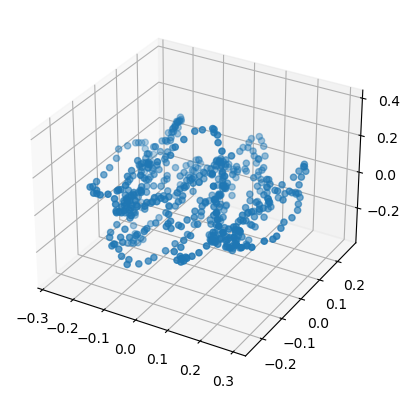

In [5]:
pos_tensor = model.distilbert.embeddings.position_embeddings.weight.data
pos_matrix = pos_tensor.to('cpu').numpy()

# apply PCA to reduce the dimensionality of the positional embeddings
pca = PCA(n_components=10)
pos_matrix_pca = pca.fit_transform(pos_matrix)

# plot variance explained
print (sum(pca.explained_variance_ratio_))
plt.bar(range(1, len(pca.explained_variance_)+1), pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

# plot first 3 components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_matrix_pca[:,0], pos_matrix_pca[:,1], pos_matrix_pca[:,2])
plt.show()

tensor(2.0174)


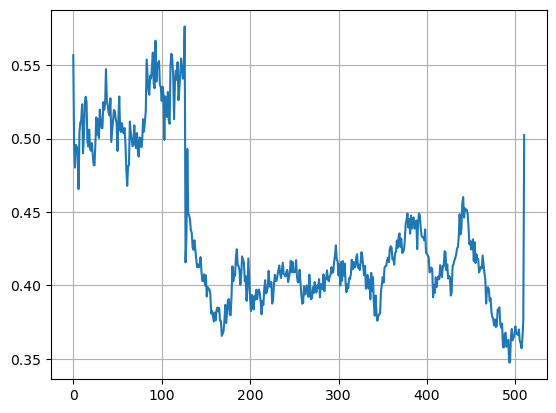

In [8]:
# show norms of each position
norms = [torch.norm(pos_tensor[i]) for i in range(pos_tensor.shape[0])]
print (norms[0]) # this is weirdly higher than others
plt.plot(norms[1:]) # something happens at position 120
plt.grid()
plt.show()

Reconstruction Error: 1.849472165107727


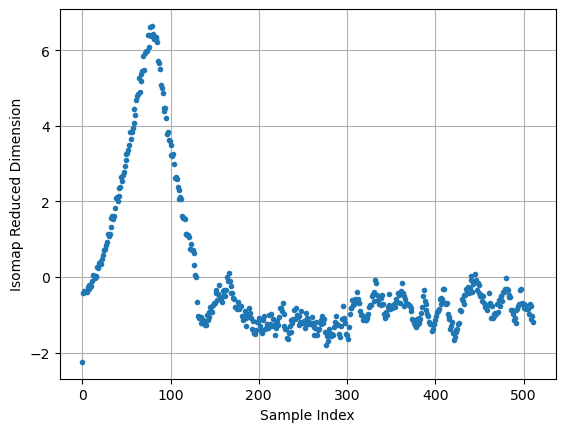

In [9]:
# Lets see if we can straighten the sqiuggly sphegettis using some dimensionality reduction technique
isomap = Isomap(n_components=1)
pos_matrix_isomap = isomap.fit_transform(pos_matrix)

reconstruction_error = isomap.reconstruction_error()
print(f"Reconstruction Error: {reconstruction_error}")

plt.plot(pos_matrix_isomap, '.')
plt.xlabel('Sample Index')
plt.ylabel('Isomap Reduced Dimension')
plt.grid()
plt.show()

Reconstruction Error for first 128 positions: 1.3878681659698486


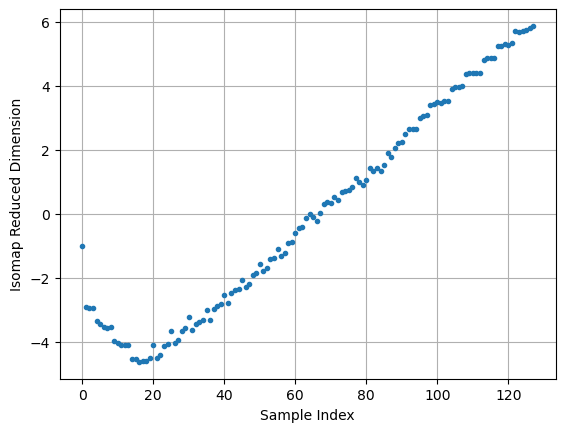

Reconstruction Error for last 128 positions: 0.7305339972178141


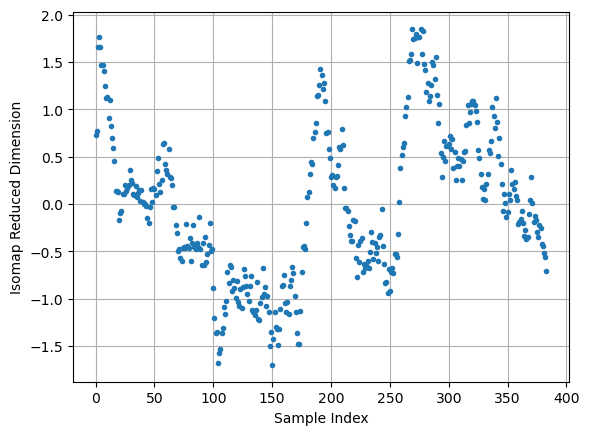

In [10]:
# seems like indexes before ~128 are seperated well but so well after that
# lets try two separate isomaps one for each side
pos_before128 = pos_matrix[:128]
pos_after128 = pos_matrix[128:]

isomap_before128 = Isomap(n_components=1)
pos_matrix_isomap_before128 = isomap_before128.fit_transform(pos_before128)

reconstruction_error = isomap_before128.reconstruction_error()
print(f"Reconstruction Error for first 128 positions: {reconstruction_error}")

plt.plot(pos_matrix_isomap_before128, '.')
plt.xlabel('Sample Index')
plt.ylabel('Isomap Reduced Dimension')
plt.grid()
plt.show()

isomap_after128 = Isomap(n_components=1)
pos_matrix_isomap_after128 = isomap_after128.fit_transform(pos_after128)

reconstruction_error = isomap_after128.reconstruction_error()
print(f"Reconstruction Error for last 128 positions: {reconstruction_error}")

plt.plot(pos_matrix_isomap_after128, '.')
plt.xlabel('Sample Index')
plt.ylabel('Isomap Reduced Dimension')
plt.grid()
plt.show()

0.4203524962067604


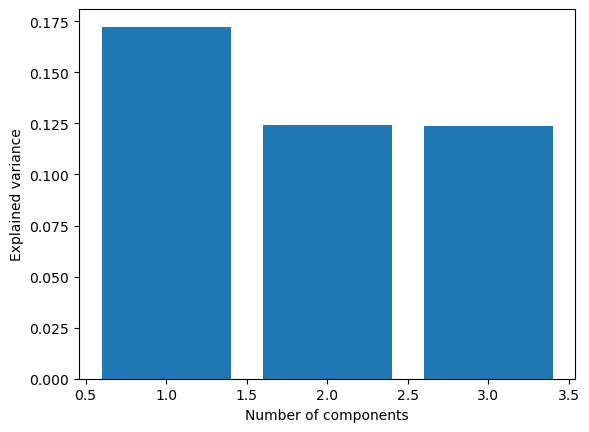

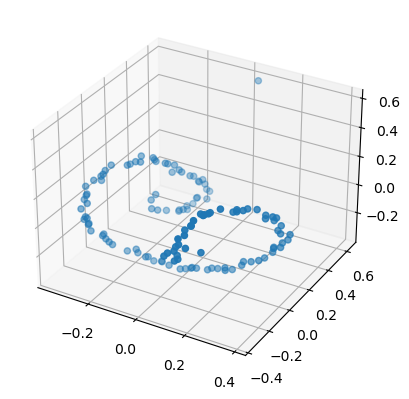

0.31004905700683594


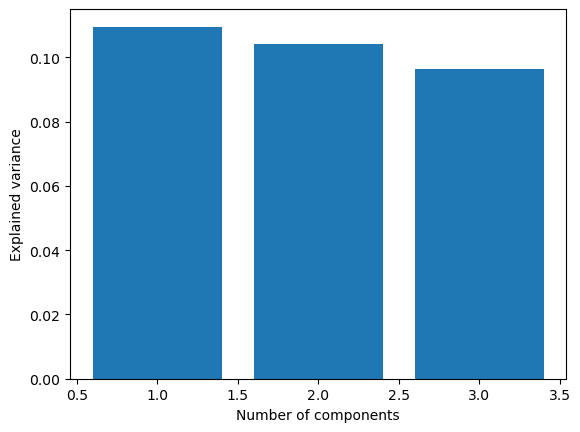

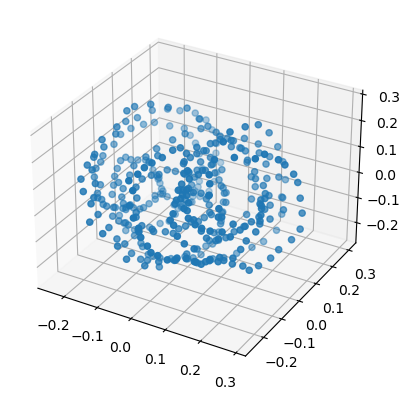

In [11]:
# lets look at pca of positions before 128
pca_before128 = PCA(n_components=3)
pos_matrix_pca_before128 = pca_before128.fit_transform(pos_before128)

# plot variance explained
print (sum(pca_before128.explained_variance_ratio_))
plt.bar(range(1, len(pca_before128.explained_variance_)+1), pca_before128.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

# plot first 3 components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_matrix_pca_before128[:,0], pos_matrix_pca_before128[:,1], pos_matrix_pca_before128[:,2])
plt.show()

# lets look at pca of positions after 128
pca_after128 = PCA(n_components=3)
pos_matrix_pca_after128 = pca_after128.fit_transform(pos_after128)

# plot variance explained
print (sum(pca_after128.explained_variance_ratio_))
plt.bar(range(1, len(pca_after128.explained_variance_)+1), pca_after128.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

# plot first 3 components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_matrix_pca_after128[:,0], pos_matrix_pca_after128[:,1], pos_matrix_pca_after128[:,2])
plt.show()

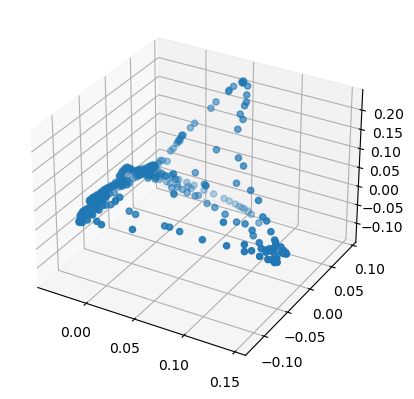

In [12]:
# isomap worked fine for first 128 positions (except for the weird u shape in the beginning) but not for positions bigger than 128
# it is peicewise linear for > 128 positions but not linear all the way. Lets try a different method

lle = LocallyLinearEmbedding(n_components=3)
pos_matrix_lle_after128 = lle.fit_transform(pos_after128)

# plot first 3 components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_matrix_lle_after128[:,0], pos_matrix_lle_after128[:,1], pos_matrix_lle_after128[:,2])
plt.show()

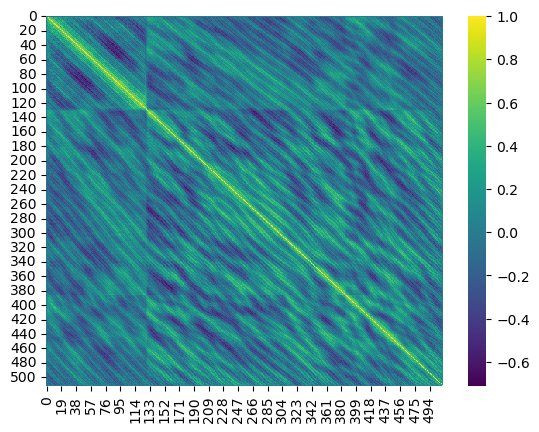

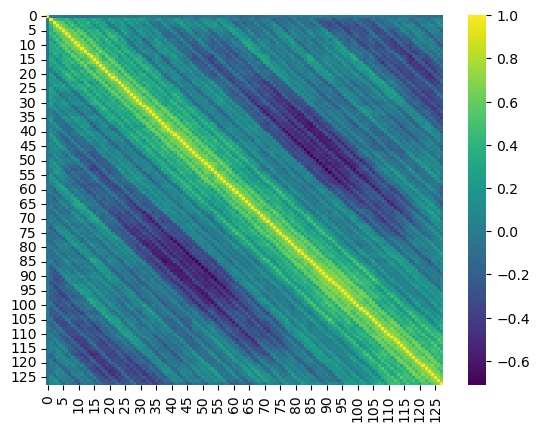

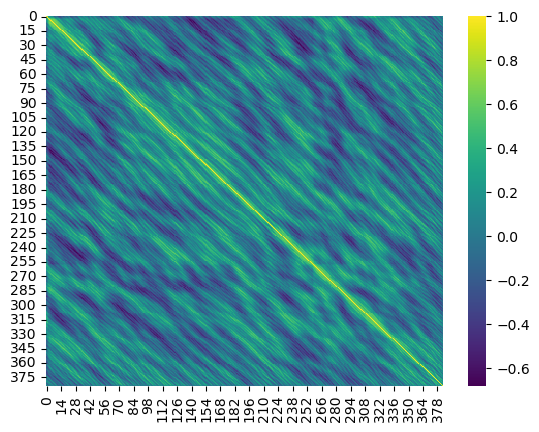

In [39]:
# lle is also not linear. But it does look like the main issue is that there are 3 different spaghettis instead of just one

# show nearest neighbors of each position
norms = torch.norm(pos_tensor, p=2, dim=1, keepdim=True)

normed_pos_tensor = pos_tensor / norms
cosine_similarity = torch.mm(normed_pos_tensor, normed_pos_tensor.T)

# heatmap
sns.heatmap(cosine_similarity, cmap='viridis')
plt.show()

# it is obvious from the heatmap that something is clearly different at position ~128

# show heatmap for <= 128 and > 128 separately
sns.heatmap(cosine_similarity[:128, :128], cmap='viridis')
plt.show()

sns.heatmap(cosine_similarity[128:, 128:], cmap='viridis')
plt.show()

In [48]:
k = 5
# show cos inverse of k nearest neighbors of each position
# before 128
_, indices = torch.topk(cosine_similarity[:128, :128], k=k, dim=1)
indices = indices.numpy()
for i in range(128):
    print(f"Position {i}: {indices[i]}, cosine similarity: {[round(float(cosine_similarity[i, j]), 2) for j in indices[i]]}")

print ("\n\n")

# after 128
_, indices = torch.topk(cosine_similarity[128:, 128:], k=k, dim=1)
indices = indices.numpy()
for i in range(len(indices)):
    print(f"Position {i+128}: {indices[i]+128}, cosine similarity: {[round(float(cosine_similarity[i+128, j+128]), 2) for j in indices[i]]}")

Position 0: [  0   1 102  88   2], cosine similarity: [1.0, 0.04, 0.01, 0.01, 0.01]
Position 1: [1 2 6 3 4], cosine similarity: [1.0, 0.54, 0.46, 0.43, 0.39]
Position 2: [2 3 4 5 1], cosine similarity: [1.0, 0.71, 0.57, 0.55, 0.54]
Position 3: [3 2 4 5 8], cosine similarity: [1.0, 0.71, 0.71, 0.6, 0.54]
Position 4: [4 3 5 2 7], cosine similarity: [1.0, 0.71, 0.71, 0.57, 0.56]
Position 5: [ 5  6  4 10  3], cosine similarity: [1.0, 0.72, 0.71, 0.61, 0.6]
Position 6: [ 6  7  5  9 11], cosine similarity: [1.0, 0.73, 0.72, 0.64, 0.61]
Position 7: [ 7  6  8  9 10], cosine similarity: [1.0, 0.73, 0.66, 0.6, 0.6]
Position 8: [ 8  9  7 13 11], cosine similarity: [1.0, 0.71, 0.66, 0.63, 0.62]
Position 9: [ 9 10  8  6 11], cosine similarity: [1.0, 0.77, 0.71, 0.64, 0.62]
Position 10: [10  9 11 15 12], cosine similarity: [1.0, 0.77, 0.73, 0.63, 0.61]
Position 11: [11 10 12 16  9], cosine similarity: [1.0, 0.73, 0.72, 0.64, 0.62]
Position 12: [12 11 17 13 10], cosine similarity: [1.0, 0.72, 0.67, 0

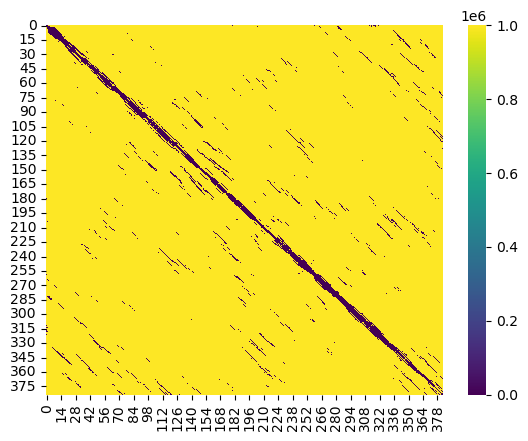

In [62]:
k = 10
norms = torch.norm(pos_tensor, p=2, dim=1, keepdim=True)

normed_pos_tensor = pos_tensor / norms
cosine_similarity = torch.mm(normed_pos_tensor, normed_pos_tensor.T)

cosine_similarity = cosine_similarity[128:, 128:]
_, indices = torch.topk(cosine_similarity, k=k, dim=1)
N = cosine_similarity.shape[0]
distance_matrix = 1000000 * np.ones((N, N))
for i in range(N):
    for j in range(k):
        distance_matrix[i, indices[i, j]] = 1 - cosine_similarity[i, indices[i, j]]
        distance_matrix[indices[i, j], i] = 1 - cosine_similarity[i, indices[i, j]]

# distance matrix heatmap
sns.heatmap(distance_matrix, cmap='viridis')
plt.show()